# Euler scheme on 2-d SDE

## General 2-d SDE

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''=========
sde_2d class init
=========='''

class SDE_2d:
    def __init__(self,
                init_state = [100., .04],
                drift = lambda x: [0.01, 0.03], #x: 2-d array
                vol = lambda x: [[0.1, 0], [0,0.1]], #x: 2-d array, vol: 2 by 2 array
                ):
        self.init_state = init_state
        self.drift = drift
        self.vol = vol
        

In [3]:
'''================
euler_2d_difference 
input:
    xh_i: 2_d current state
    dt: 1_d time diff
    dw: 2_d bm increase
output:
    xh_i_diff: 2_d increase for euler solution
=================='''

def euler_2d_diff(self, xh_i, dt, dw):
    #set SDE param
    mu = self.drift
    sigma = self.vol
    
    return np.array(mu(xh_i))*dt + np.matmul(sigma(xh_i), dw)

SDE_2d.euler_diff = euler_2d_diff

In [4]:
'''==========
euler method as a method of SDE_2d
input:
    time grid: np.array (t_i: i = 0, 1, ..., n)
output: 
    euler solution: np.array (Xh_i: i = 0, 1, ..., n)
==========='''

def euler_2d(self, grid):
    #step_size dt
    dt = np.diff(grid)
    
    #generate 2d bm icrement
    dw = np.array([np.random.normal(0, np.sqrt(dt)) for i in range(2)])

    #initialize euler solution
    x0 = self.init_state #2_d array
    xh = np.array([x0[i] + np.zeros(grid.shape) for i in range(2)])
 
    
    #run euler
    for i in range(dt.size):
        xh[:,i+1] = xh[:,i] + self.euler_diff(xh[:,i], dt[i], dw[:,i]) #euler iteration        
    return xh

SDE_2d.euler = euler_2d

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


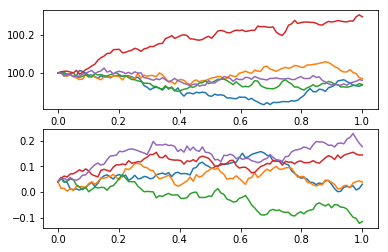

In [5]:
'''=============
test SDE_2d.euler
plot paths
=============='''
sde1 = SDE_2d()
grid = np.linspace(0,1,100)

plt.figure()
for i in range(5):
    xh = sde1.euler(grid)
    plt.subplot(211)
    plt.plot(grid, xh[0]) #x[0]
    plt.subplot(212)
    plt.plot(grid, xh[1]) #x[1]


## Heston model

In [6]:
'''============
Heston class inherited from sde_2d
============='''

class Heston(SDE_2d):
    def __init__(self,
                 init_state = [100., .04],
                 r = .05,
                 kappa = 1.2,
                 theta = .04,
                 xi = .3,
                 rho = .5,
                ):
        self.init_state = init_state
        rho_bar = np.sqrt(1 - rho**2)
        self.drift = lambda x: [r*x[0], kappa*(theta -x[1])]
        self.vol = lambda x: [
            [np.sqrt(x[1])*x[0], 0], 
            [xi*np.sqrt(x[1])*rho, xi*np.sqrt(x[1])*rho_bar]
        ]
                              

In [7]:
'''================
euler_2d_difference for Heston class to overide SDE_2d class member

input:
    xh_i: 2_d current state
    dt: 1_d time diff
    dw: 2_d bm increase
output:
    xh_i_diff: 2_d increase for euler solution
=================='''

def euler_heston_diff(self, xh_i, dt, dw):
    #set SDE param
    mu = self.drift
    sigma = self.vol
    xh_i[1] = np.max([0, xh_i[1]]) #new line to override
    
    return np.array(mu(xh_i))*dt + np.matmul(sigma(xh_i), dw)

Heston.euler_diff = euler_heston_diff #override

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


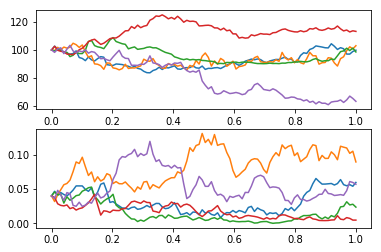

In [8]:
'''==========
test plot euler paths for Heston
=========='''
heston1 = Heston()

grid = np.linspace(0,1,100)

plt.figure()
for i in range(5):
    xh = heston1.euler(grid)
    plt.subplot(211)
    plt.plot(grid, xh[0]) #x[0]
    plt.subplot(212)
    plt.plot(grid, xh[1]) #x[1]

Test Euler method: 
We implement ordinary MC to find BSM call price, compare with exact price, see [pdf](../doc/euler_sde_2d.pdf)

In [9]:
'''=========
option class init
=========='''
class EuropeanOption:
    def __init__(self,
                otype = 1, # 1: 'call'
                        # -1: 'put'
                strike = 110.,
                maturity = 1.
                ):
        self.otype = otype
        self.strike = strike
        self.maturity = 1.
        
    def payoff(self, s): #s: excercise price
        otype = self.otype
        k = self.strike
        maturity = self.maturity
        return np.max([0, (s - k)*otype])
        



In [10]:
#initiate option and heston instances

heston1 = Heston()
option1 = EuropeanOption(otype = 1, strike = 100., maturity = 1.)

In [11]:
'''
==========
option pricing based euler OMC
=========='''

r = heston1.drift([1,1])[0]

num_step = 10
time_grid = np.linspace(0, option1.maturity, num_step+1)

num_path = 10000
terminal_price = [heston1.euler(time_grid)[0, -1] for i in range(num_path)]


#compute call price
option1.otype = 1
payoff = [option1.payoff(s) for s in terminal_price]
call_value = np.exp(-r*option1.maturity)*np.average(payoff)
print('call price is ' + str(call_value))



call price is 10.126381105583322


In [12]:

#compute put price
option1.otype = -1
payoff = [option1.payoff(s) for s in terminal_price]
put_value = np.exp(-r*option1.maturity)*np.average(payoff)
print('put price is ' + str(put_value))


put price is 5.119539015081175
